In [5]:
import cv2
cv = cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
import face_alignment
import collections
import glob
from skimage import io
from EVE.src.datasources.eve_sequences import EVESequencesBase

dataset = EVESequencesBase(
    'sample/eve_dataset',
    participants_to_use=['train01']
)
dataloader = iter(torch.utils.data.DataLoader(dataset))

# calibrate using chessboards

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('../chessboards/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    if ret == True:
        print(fname)
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

../chessboards/left08.jpg
../chessboards/left14.jpg
../chessboards/left01.jpg
../chessboards/left03.jpg
../chessboards/left02.jpg
../chessboards/left12.jpg
../chessboards/left06.jpg
../chessboards/left07.jpg
../chessboards/left13.jpg
../chessboards/left05.jpg
../chessboards/left04.jpg


In [ ]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
mtx

array([[534.07088623,   0.        , 341.53407107],
       [  0.        , 534.11914798, 232.94565221],
       [  0.        ,   0.        ,   1.        ]])

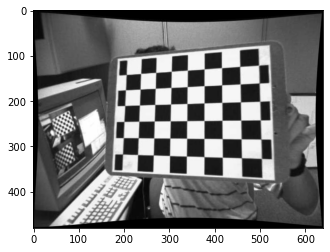

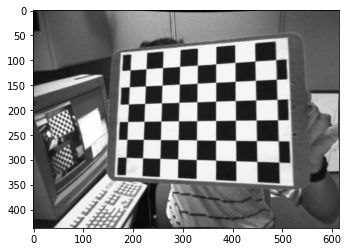

In [ ]:
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
plt.imshow(dst)
plt.show()
plt.imshow(dst[y:y+h, x:x+w])
plt.show()

--- 

In [491]:
def plot_preds_3d(preds, img):
    plot_style = dict(marker='o',
                      markersize=4,
                      linestyle='-',
                      lw=2)

    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
                  'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
                  'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
                  'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
                  'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
                  'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                  'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                  'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
                  'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
                  }

    fig = plt.figure(figsize=plt.figaspect(.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img)

    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

    ax.axis('off')

    # 3D-Plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(preds[:, 0] * 1.2,
                      preds[:, 1],
                      preds[:, 2],
                      c='cyan',
                      alpha=1.0,
                      edgecolor='b')

    for pred_type in pred_types.values():
        ax.plot3D(preds[pred_type.slice, 0] * 1.2,
                  preds[pred_type.slice, 1],
                  preds[pred_type.slice, 2], color='blue')

    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()

In [492]:
def get_matrices_using_landmarks(img):
    h, w, c = img.shape
    fa2d = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='sfd')
    fa3d = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='blazeface')
    landmarks_2d = fa2d.get_landmarks(img)[0]
    landmarks_3d= fa3d.get_landmarks(img)[0]
    plot_preds_3d(landmarks_3d, img)
    intrinsic_matrix = cv2.initCameraMatrix2D([landmarks_3d],
                                              [landmarks_2d], 
                                              (w, h))
    ret, rvec, tvec, inliers = cv2.solvePnPRansac(landmarks_3d, 
                                                  landmarks_2d,
                                                  intrinsic_matrix, 
                                                  distortion,
                                                  flags=0)
    rotation_m, _ = cv2.Rodrigues(rvec)
    extrinsic_matrix = np.hstack([rotation_m, tvec])
    extrinsic_matrix = np.vstack([extrinsic_matrix, [0, 0, 0, 1]])
    return intrinsic_matrix, extrinsic_matrix

In [489]:
def get_matrices_using_chessboard(img):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((6*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    distortion = np.zeros(4)

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    plt.imshow(cv.drawChessboardCorners(img.copy(), (7, 6), corners, ret))
    plt.show()
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ret, rvec, tvec, inliers = cv2.solvePnPRansac(objpoints[0], imgpoints[0], mtx, distortion)
    rotation_m, _ = cv2.Rodrigues(rvec)
    extrinsic_matrix = np.hstack([rotation_m, tvec])
    extrinsic_matrix = np.vstack([extrinsic_matrix, [0, 0, 0, 1]])
    return intrinsic_matrix, extrinsic_matrix

In [2]:
def solve_extrinsic_matrix(objpoints, imgpoints, mtx, dist, rvecs, tvecs):
    assert len(objpoints) == len(imgpoints)
    objpoints = np.array(objpoints).astype(float)
    imgpoints = np.array(imgpoints).astype(float)
    ret, rvec, tvec, inliers = cv2.solvePnPRansac(objpoints,
                                                  imgpoints,
                                                  mtx,
                                                  dist, 
                                                  rvecs,
                                                  tvecs)
    rotation_m, _ = cv2.Rodrigues(rvec)
    extrinsic_matrix = np.hstack([rotation_m, tvec])
    extrinsic_matrix = np.vstack([extrinsic_matrix, [0, 0, 0, 1]])
    return extrinsic_matrix, rvec, tvec

---

# calibration using 3d and 2d face landmarks

In [471]:
img = cv2.imread('/Users/piotrostrowski/face_and_chessboard.jpg')

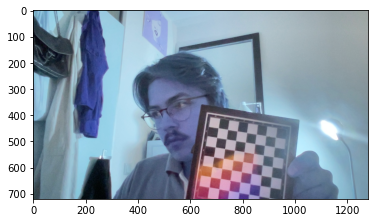

In [472]:
plt.imshow(img)

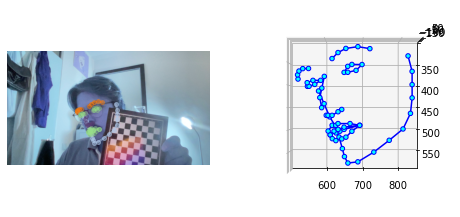

(array([[ 92.86727743,   0.        , 639.5       ],
        [  0.        ,  92.86727743, 359.5       ],
        [  0.        ,   0.        ,   1.        ]]),
 array([[   0.95995529,    0.06119819,   -0.27338731, -646.81351012],
        [  -0.06219443,    0.99805138,    0.00502974, -322.69615922],
        [   0.27316239,    0.01217485,    0.96189089,  -70.99304516],
        [   0.        ,    0.        ,    0.        ,    1.        ]]))

In [493]:
get_matrices_using_landmarks(img)

# calibration using chessboard

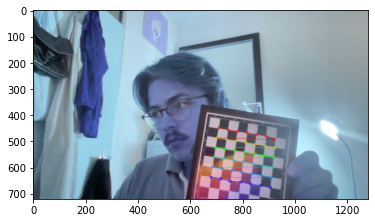

In [495]:
intrinsic_matrix, _ = get_matrices_using_chessboard(img)

In [496]:
newcameramtx, roi = cv.getOptimalNewCameraMatrix(intrinsic_matrix, dist, (w,h), 1, (w,h))

In [497]:
newcameramtx

array([[1160282.375     ,       0.        ,     614.93732187],
       [      0.        ,  216500.53125   ,     597.35144151],
       [      0.        ,       0.        ,       1.        ]])

In [498]:
intrinsic_matrix

array([[444.07459991,   0.        , 959.5       ],
       [  0.        , 444.07459991, 539.5       ],
       [  0.        ,   0.        ,   1.        ]])

---

# undistort using landmarks

In [628]:
objpoints = []
imgpoints = []

In [640]:
import glob

In [648]:
fname = glob.glob('*.jpg')[0]
fa3d.get_landmarks(cv2.imread(fname))[0].shape

(68, 3)

In [ ]:
objpoints = []
imgpoints = []
for fname in glob.glob('*.jpg'):
    try:
        objpoint = fa3d.get_landmarks(cv2.imread(fname))[0]
        objpoint.shape
        imgpoint = fa2d.get_landmarks(cv2.imread(fname))[0]
        imgpoint.shape
        objpoints.append(objpoint)
        imgpoints.append(imgpoint)
    except:
        pass

In [657]:
assert len(objpoints) == len(imgpoints)

In [665]:
h, w, c = cv2.imread('./0.jpg').shape

In [671]:
intrinsic_matrix = cv2.initCameraMatrix2D(objpoints,
                                          imgpoints, 
                                          (w, h))

In [673]:
intrinsic_matrix

array([[ 67.53846386,   0.        , 639.5       ],
       [  0.        ,  67.53846386, 359.5       ],
       [  0.        ,   0.        ,   1.        ]])

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints,
                                                  imgpoints,
                                                  (w, h),
                                                  intrinsic_matrix,
                                                  None, 
                                                  flags=cv2.CALIB_USE_INTRINSIC_GUESS)

In [680]:
mtx

array([[ 67.54704194,   0.        , 639.49996407],
       [  0.        ,  67.5384359 , 359.50007028],
       [  0.        ,   0.        ,   1.        ]])

In [ ]:
img = cv.imread('3.jpg')

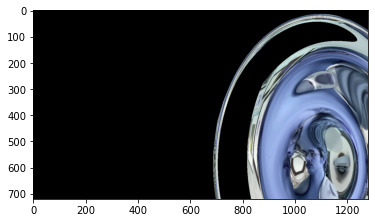

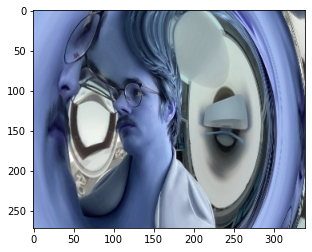

In [687]:
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
plt.imshow(dst)
plt.show()
plt.imshow(dst[y: y + h, x: x + w])
plt.show()